## Single Object Detection using Pytorch on Pascal VOC 2007 dataset
### Understanding the Pascal VOC
Pacal VOC can be download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). The orginal annotations were in XML. The json annotations can be downloaded from [here](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip)

In [192]:
import os
from pathlib import Path
import json
import random
import math
import numpy as np
import collections

from matplotlib import pyplot as plt
from matplotlib import patches, patheffects
import cv2

import torch

from fastai.dataset import open_image

%matplotlib  inline
%reload_ext autoreload
%autoreload 2

In [193]:
#set paths to the pascal json files
homedir = os.path.expanduser('~')
pascal_home = Path(os.path.join(homedir,'data/pascal_voc'))
pascal_jhome = pascal_home.joinpath('pascal_json')
list(pascal_jhome.iterdir())

train_json = json.load(pascal_jhome.joinpath('pascal_train2007.json').open())
print(train_json.keys())

dict_keys(['images', 'type', 'annotations', 'categories'])


### JSON contents

Let us check the content of each of these dict keys

In [194]:
print('images: ',len(train_json['images']))
train_json['images'][:3]

images:  2501


[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}]

In [195]:
print('type: ', train_json['type'])

type:  instances


In [196]:
print('annotations: ', len(train_json['annotations']))
train_json['annotations'][:2]

annotations:  7844


[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [197]:
print('categories: ', len(train_json['categories']))
train_json['categories'][:3]
category_id_names = {o['id']:o['name'] for o in train_json['categories']}

categories:  20


In [198]:
#create id:filename mapping
train_id_filename = {o['id']:o['file_name'] for o in train_json['images']}

### Viewing the images

In [199]:
imagedir = pascal_home.joinpath('2007/VOCdevkit/VOC2007/JPEGImages')
print('No of images: ',len(list(imagedir.iterdir())))

No of images:  5011


In [219]:
def show_img(image, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

"""
expected format is of bounding box is [x,y,width,height]. Topleft corner is x=0,y=0.
"""
def draw_rect(ax,b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax,xy,txt,size=14):
    text = ax.text(*xy,txt, verticalalignment='top',color='white',fontsize=size, weight='bold')
    draw_outline(text,1)
    
#convert bounding box from height_width (voc) bounding box format to numpy format (top-left, bottom-right).
#note that (0,0) is top-left corner
def bb_np_to_hw(a): 
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

#convert bounding box from numpy format (top-left, bottom-right) to height_width
def bb_hw_to_np(bb):
    return np.array([bb[1],bb[0],bb[1]+bb[3]-1,bb[0]+bb[2]-1])

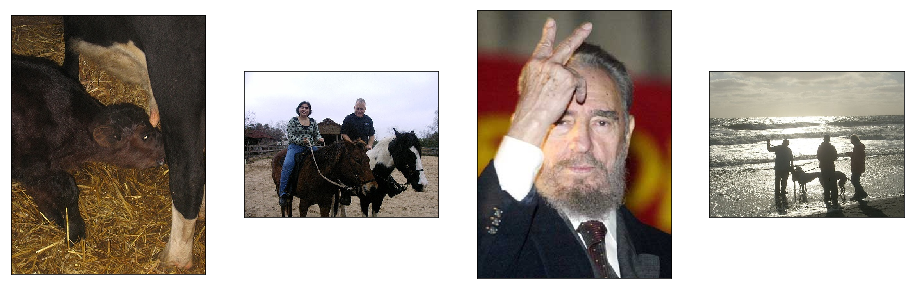

In [201]:
#show sample images
no_samples = 5
sample_images = random.choices(list(imagedir.iterdir()),k=no_samples)
fig, axs = plt.subplots(nrows=math.floor(no_samples/4),ncols=4,figsize=(16,12))
for idx, ax in enumerate(axs.flat):
    im = open_image(sample_images[idx])
    show_img(im,ax=ax)

### Display bounding box of single image
Here we can see that pascal voc annoations are in the format [x0,y0,width,height], where (x0, y0) is the top left hand corner of the BB. (0,0) would be the top-left corner of the image. 

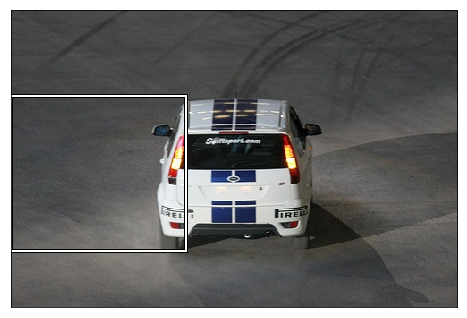

In [223]:
image_name = '000012.jpg'
image_path = imagedir.joinpath(image_name)
fig, axs = plt.subplots(1,1,figsize=(8,8))
im = open_image(image_path.as_posix())
axs.imshow(im)
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
# bb_voc = [155, 96, 196, 174]
bb_voc = [0, 96, 196, 174]
draw_rect(axs,bb_voc)

Let us collect annotations for each image, with bounding boxes in numpy format

In [228]:
train_img_anno_np = collections.defaultdict(lambda: [])
for anno in train_json['annotations']:
    if anno['ignore']:
        continue
    bb = anno['bbox']
    #convert bounding boxes to numpy format
    bb = bb_hw_to_np(bb)
    train_img_anno_np[anno['image_id']].append((bb,anno['category_id']))
        
len(train_img_anno_np)

2501

### Display image with annotations

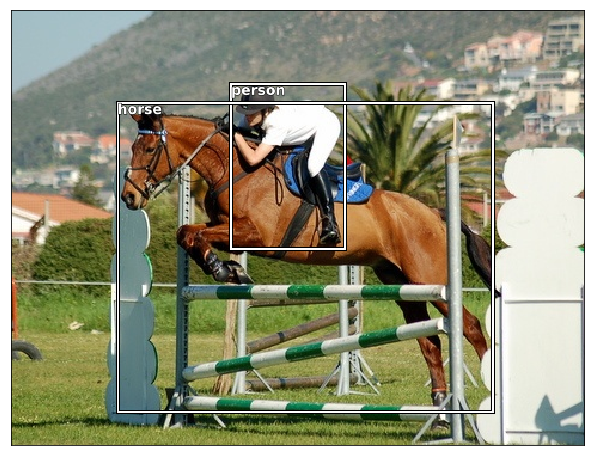

In [236]:
def draw_idx(idx, annos=None):
    filename = train_id_filename[idx]
    image_path = imagedir.joinpath(filename)
    img = open_image(image_path)
    fig, ax = plt.subplots(figsize=(16,8))
    show_img(img,ax=ax)
    if not annos:
        annos = train_img_anno_np[idx]
    for anno in annos:
        bb = bb_np_to_hw(anno[0])
        draw_rect(ax,bb)
        draw_text(ax,bb[:2],category_id_name[anno[1]])
        
draw_idx(17)

### Find largest bounding box in each image

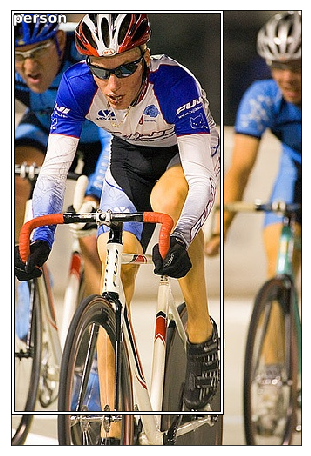

In [237]:
#get the largest annotation by size
def get_largest_anno(idx):
    bbs_np = train_img_anno_np[idx]
    if not bbs_np:
        return
    largest_area = 0
    largest_i = 0
    for i, bb in enumerate(bbs_np):
        area = (bb[0][2] - bb[0][0]) * (bb[0][3] - bb[0][1])
        if area >= largest_area:
            largest_area = area
            largest_i = i
    return bbs_np[largest_i]

#test it
anno = get_largest_anno(23)
draw_idx(23,annos=[anno])

### create a dictionary of largest annotations

In [240]:
train_img_large_anno_np = {idx:get_largest_anno(idx) for idx, o in train_img_anno.items()}
len(train_img_large_anno_np)

2501